- load the results of zero-shot bart predictions on the entire ED dataset
- use gaussian naive bayes to find optimal threshold, and convert probabilities into labels
    - use true/false labels instead of entailment/neutral/contradiction
- write the labels into either a CSV or dataset file (tell Karen)
- get evaluation metrics like precision, recall, etc.
    - for accuracy, consider only the positive class

In [11]:
from transformers import pipeline
import numpy as np
import pandas as pd
from sklearn import metrics
import torch
import datasets
from datasets import Dataset
from transformers.pipelines.pt_utils import KeyDataset
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

import sys  
sys.path.insert(0, '/root/Project-CS224N-ED-Disposition/')
from scripts import utils
import importlib
importlib.reload(utils)

<module 'scripts.utils' from '/root/Project-CS224N-ED-Disposition/scripts/utils.py'>

In [3]:
raw_predictions = datasets.load_from_disk("/root/data/zero_shot_predictions/all")
print(raw_predictions)
# print(raw_predictions[0])

Dataset({
    features: ['sequence', 'labels', 'scores'],
    num_rows: 146149
})


In [4]:
# takes ~1 minute
pdf = utils.zero_shot_results_to_pandas(raw_predictions)
pdf

Loading cached processed dataset at /root/data/zero_shot_predictions/all/cache-052c2ba9d8fa9103.arrow


,sequence,Pneumonia,Pneumothorax,Pleural Effusion,Edema,Fracture,Infection,Aspiration,Cardiomegaly,Opacities,...,Small bowel obstruction,Pancreatitis,Splenic laceration,Liver laceration,Colitis,Pyelonephritis,Nephrolithiasis,Malignancy,Pericaridial effusion,Aortic dissection
0,1. Interval increase in perihilar opacities a...,0.524612,0.118200,0.185744,0.929120,0.009016,0.000204,0.045569,0.002341,0.920819,...,0.000184,0.000046,0.001241,0.000098,0.000074,0.008013,0.018194,0.000920,0.737004,0.000117
1,1. No acute intracranial abnormality. 2. Mil...,0.000776,0.001084,0.096998,0.106327,0.178153,0.001479,0.086613,0.009535,0.090323,...,0.000123,0.000875,0.023919,0.000157,0.011096,0.050141,0.028645,0.003348,0.111382,0.000498
2,1. Multiple loops of dilated small bowel with...,0.007977,0.072368,0.182043,0.070339,0.168524,0.018739,0.442881,0.045323,0.741595,...,0.967760,0.001242,0.050261,0.004344,0.007286,0.059447,0.017711,0.960237,0.214792,0.003933
3,1. Interval increased loculated moderate meta...,0.004349,0.008329,0.367867,0.007522,0.025490,0.000482,0.006146,0.002442,0.441353,...,0.000492,0.000209,0.003195,0.000482,0.000569,0.001479,0.001017,0.219973,0.001170,0.000283
4,1. Redemonstrated fracture of the femoral hea...,0.001767,0.004236,0.032812,0.011500,0.964834,0.002214,0.136899,0.050998,0.378758,...,0.002143,0.001374,0.004023,0.000586,0.003734,0.010466,0.022915,0.014504,0.008745,0.001433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146144,1. Acute superior endplate compression deform...,0.018393,0.060820,0.451436,0.412637,0.755615,0.062306,0.332372,0.260980,0.565540,...,0.011410,0.009234,0.292709,0.014308,0.135798,0.317787,0.102796,0.059738,0.455190,0.036457
146145,1. Diffuse anasarca and mesenteric edema. Pat...,0.259759,0.308534,0.905350,0.909280,0.350700,0.020335,0.230740,0.182957,0.448288,...,0.006509,0.002375,0.641667,0.020484,0.012868,0.124073,0.140058,0.232137,0.229874,0.010458
146146,1. No ultrasound evidence of deep venous thro...,0.005479,0.008577,0.021521,0.012299,0.011921,0.003024,0.062111,0.033632,0.033661,...,0.000778,0.000996,0.030827,0.005801,0.001874,0.008241,0.035728,0.004741,0.014146,0.013719
146147,1. Mild fluid overload with new small pleural...,0.937115,0.457915,0.980537,0.189899,0.097697,0.895856,0.441919,0.020421,0.953561,...,0.137809,0.000449,0.024316,0.001573,0.003006,0.014492,0.013508,0.003028,0.045328,0.003474


In [5]:
pdf.to_csv('/root/data/zero_shot_predictions/scores.csv')

In [6]:
chex_df = pd.read_csv('/root/data/chexbert_results.csv')
chex_df.head()

,index,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding,Report Impression
0,0,NaN,NaN,1.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1. Interval increase in perihilar opacities a...
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1. No acute intracranial abnormality. 2. Mil...
2,2,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1. Multiple loops of dilated small bowel with...
3,3,NaN,NaN,NaN,NaN,NaN,1.0,-1.0,-1.0,NaN,1.0,NaN,NaN,NaN,NaN,1. Interval increased loculated moderate meta...
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1. Redemonstrated fracture of the femoral hea...


In [7]:
# results are very similar to zero_shot_results.ipynb, which only evaluated 30k rows
for label in utils.chex_labels:
    utils.evaluate_naive_bayes(pdf, chex_df, label)

Fracture
              precision    recall  f1-score   support

         0.0       0.99      0.94      0.96    130038
         1.0       0.64      0.92      0.75     16111

    accuracy                           0.93    146149
   macro avg       0.81      0.93      0.86    146149
weighted avg       0.95      0.93      0.94    146149

AUC 0.9265659468920546
Edema
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99    139224
         1.0       0.65      0.88      0.75      6925

    accuracy                           0.97    146149
   macro avg       0.82      0.93      0.87    146149
weighted avg       0.98      0.97      0.97    146149

AUC 0.9301084520885337
Cardiomegaly
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98    143048
         1.0       0.38      0.60      0.46      3101

    accuracy                           0.97    146149
   macro avg       0.68      0.79      0.72    146149


In [8]:
labels_df = utils.get_labels(pdf, chex_df)
labels_df

,sequence,Pneumonia,Pneumothorax,Pleural Effusion,Edema,Fracture,Infection,Aspiration,Cardiomegaly,Opacities,...,Small bowel obstruction,Pancreatitis,Splenic laceration,Liver laceration,Colitis,Pyelonephritis,Nephrolithiasis,Malignancy,Pericaridial effusion,Aortic dissection
0,1. Interval increase in perihilar opacities a...,False,False,False,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
1,1. No acute intracranial abnormality. 2. Mil...,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1. Multiple loops of dilated small bowel with...,False,False,False,False,False,False,False,False,True,...,True,False,False,False,False,False,False,True,False,False
3,1. Interval increased loculated moderate meta...,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1. Redemonstrated fracture of the femoral hea...,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146144,1. Acute superior endplate compression deform...,False,False,False,False,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
146145,1. Diffuse anasarca and mesenteric edema. Pat...,False,False,True,True,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
146146,1. No ultrasound evidence of deep venous thro...,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
146147,1. Mild fluid overload with new small pleural...,True,False,True,False,False,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [9]:
labels_df.to_csv('/root/data/zero_shot_predictions/labels_t50.csv')

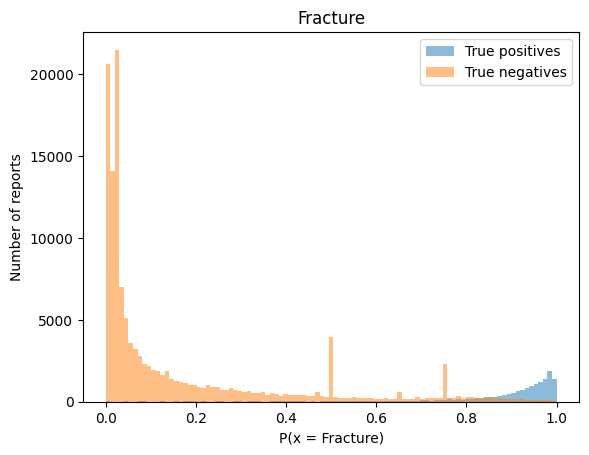

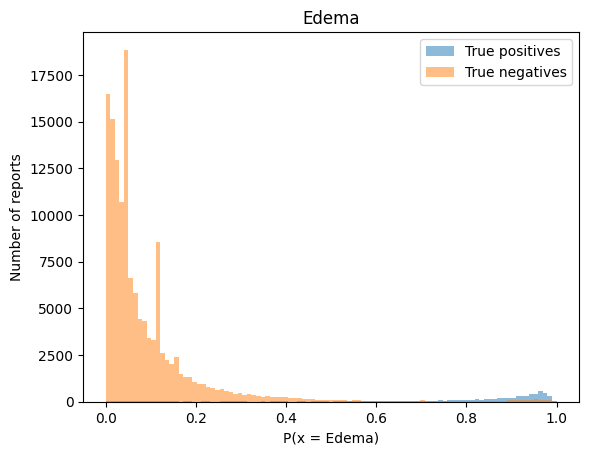

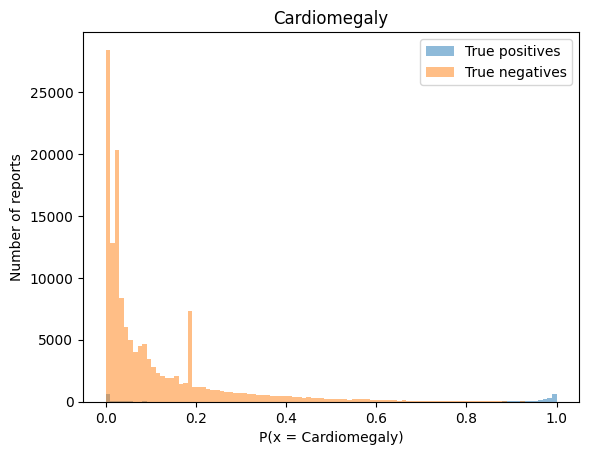

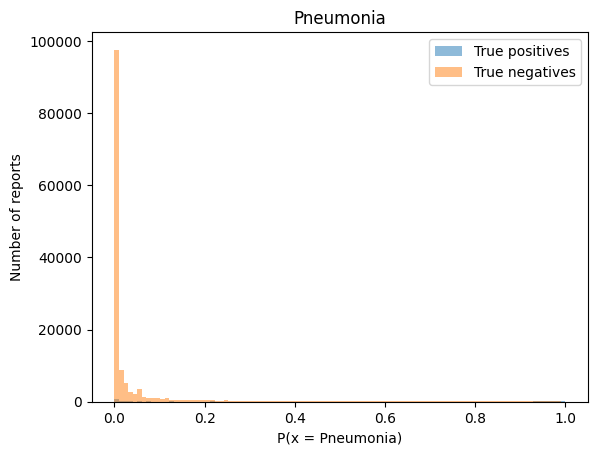

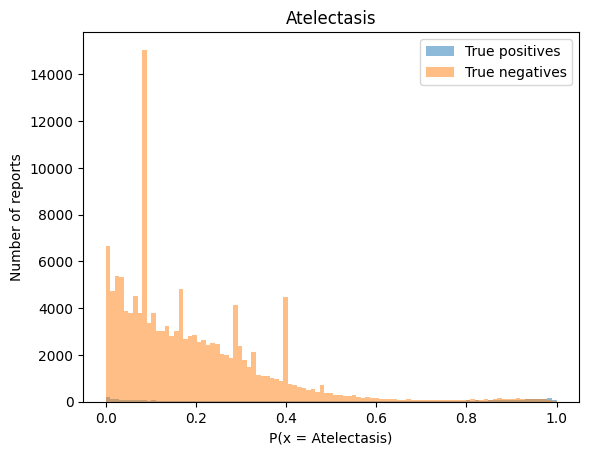

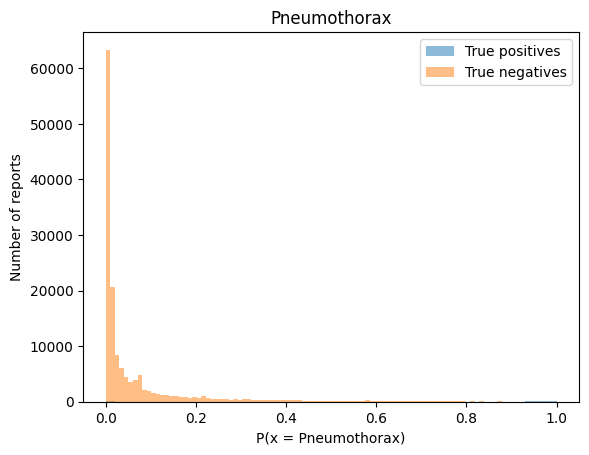

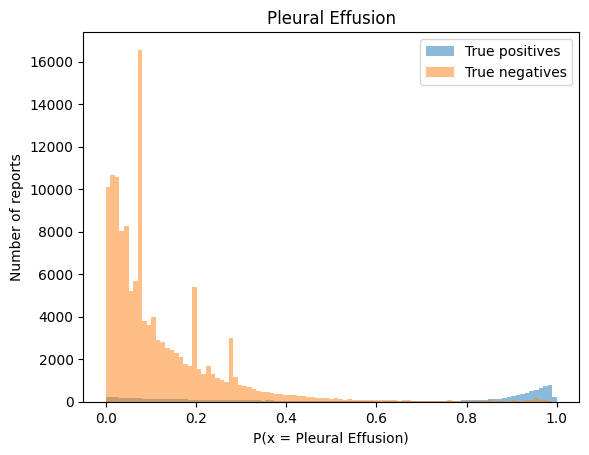

In [20]:
def compare_hist(y_pred, y_true, scale="", title=""):
    assert y_pred.shape == y_true.shape
    df = pd.DataFrame({ 'y_pred': y_pred, 'y_true': y_true })
    
    true_scores = df[df["y_true"] == 1]["y_pred"]
    false_scores = df[df["y_true"] != 1]["y_pred"]
#     print(true)
    bins = np.linspace(0, 1, 100)

    plt.hist(true_scores, bins, alpha=0.5, label='True positives')
    plt.hist(false_scores, bins, alpha=0.5, label='True negatives')
    plt.legend(loc='upper right')
    if scale == 'log':
        plt.yscale('log')
    plt.title(title)
    plt.xlabel(f"P(x = {title})")
    plt.ylabel(f"Number of reports")
    plt.show()

# compare_hist(result_l2v["Pneumonia"], result_chexbert["Pneumonia"], scale="log")
for label in utils.chex_labels:
    compare_hist(pdf[label], chex_df[label], scale="", title=label)